# Imports

In [1]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Brazilian states
import geobr

import warnings

# Functions

In [2]:
def is_decimal(string):
    '''
    Checks if a string is a decimal number.
    Input: string
    Output: True for decimal numbers.
    '''
    try:
        float_value = float(string)
        return True
    except ValueError:
        return False

In [3]:
def hotencode(data, columns):
    '''
    Performs the hot encode process.
    Input: data=Dataframe, columns=List of columns names.
    '''
    for key in columns:
        encode = pd.get_dummies(data[key])
        data.drop(key, axis=1, inplace=True)
        
        data = pd.concat([data, encode], axis=1)
        
    return data

# Load data


In [4]:
pathDicionario = "./dados/Data_Dictionary.csv"

path = './dados/BRAZIL_CITIES.csv'
data = pd.read_csv(path, sep=";", decimal=",")

# path = './dados/BRAZIL_CITIES_REV2022.CSV'
# data = pd.read_csv(path)

print("Shape: ", data.shape)

pd.set_option('display.max_columns', len(data.columns))

Shape:  (5573, 81)


# Exploratory Analysis

In [5]:
data.head(1)

CITY STATE  CAPITAL  IBGE_RES_POP  IBGE_RES_POP_BRAS  \
0  Abadia De Goiás    GO        0        6876.0             6876.0   

   IBGE_RES_POP_ESTR  IBGE_DU  IBGE_DU_URBAN  IBGE_DU_RURAL  IBGE_POP  IBGE_1  \
0                0.0   2137.0         1546.0          591.0    5300.0    69.0   

   IBGE_1-4  IBGE_5-9  IBGE_10-14  IBGE_15-59  IBGE_60+  IBGE_PLANTED_AREA  \
0     318.0     438.0       517.0      3542.0     416.0              319.0   

   IBGE_CROP_PRODUCTION_$  IDHM Ranking 2010   IDHM IDHM_Renda  \
0                  1843.0             1689.0  0.708      0.687   

  IDHM_Longevidade IDHM_Educacao          LONG           LAT    ALT  PAY_TV  \
0             0.83         0.622  -49.44054783  -16.75881189  893.6   360.0   

   FIXED_PHONES    AREA REGIAO_TUR CATEGORIA_TUR  ESTIMATED_POP RURAL_URBAN  \
0         842.0  147.26        NaN           NaN         8583.0      Urbano   

  GVA_AGROPEC GVA_INDUSTRY GVA_SERVICES GVA_PUBLIC  GVA_TOTAL     TAXES  \
0         6.2     27991.25     74750.32   36915.04    145857.6  20554.2   

      GDP  POP_GDP GDP_CAPITA         GVA_MAIN  MUN_EXPENDIT  COMP_TOT  \
0  166.41   8053.0   20664.57  Demais serviços    28227691.0     284.0   

   COMP_A  COMP_B  COMP_C  COMP_D  COMP_E  COMP_F  COMP_G  COMP_H  COMP_I  \
0     5.0     1.0    56.0     0.0     2.0    29.0   110.0    26.0     4.0   

   COMP_J  COMP_K  COMP_L  COMP_M  COMP_N  COMP_O  COMP_P  COMP_Q  COMP_R  \
0     5.0     0.0     2.0    10.0    12.0     4.0     6.0     6.0     1.0   

   COMP_S  COMP_T  COMP_U  HOTELS  BEDS  Pr_Agencies  Pu_Agencies  Pr_Bank  \
0     5.0     0.0     0.0     NaN   NaN          NaN          NaN      NaN   

   Pu_Bank  Pr_Assets  Pu_Assets    Cars  Motorcycles  Wheeled_tractor  UBER  \
0      NaN        NaN        NaN  2158.0       1246.0              0.0   NaN   

   MAC  WAL-MART  POST_OFFICES  
0  NaN       NaN           1.0

## Map

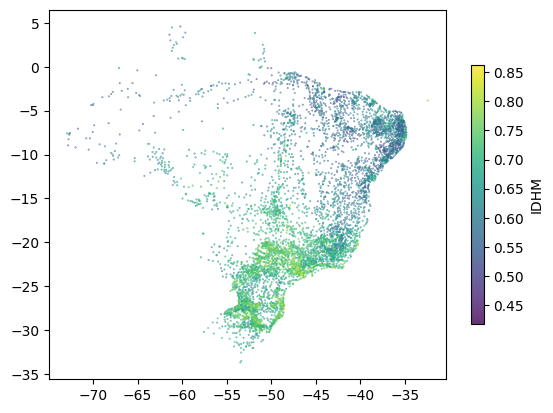

In [6]:
warnings.filterwarnings('ignore')

## Download the spatial limits of the states of Brazil
# estados = geobr.read_state()

## Ploting the Brazil states
# estados.plot(color='none', edgecolor='dimgray', linewidth=0.3,figsize=(8,8))

# IDHM data
mask = data["LONG"] != 0
plt.scatter(list(map(float,data[mask]['LONG'])), list(map(float,data[mask]['LAT'])),
            marker = ".", 
            c = list(map(float,data[mask]['IDHM'])),
            s = list(map(float,data[mask]['IDHM'])), 
            alpha = 0.8,
            zorder = 0)

# mask = data["LONG"] != 0
# plt.scatter(data[mask]['LONG'], data[mask]['LAT'], 
#             marker = ".", 
#             c = data[mask]['IDHM'],
#             s = data[mask]['IDHM'], 
#             alpha = 0.8,
#             zorder = 0)

colorbar = plt.colorbar(shrink=0.7)
colorbar.set_label('IDHM')

plt.show()
plt.close()

warnings.filterwarnings('default')

## Drop missing data and formating

In [6]:
# Percentage of missing data.
percentual = 100*data.isnull().sum()/len(data)

# cut in "percent"
percent = 10
cut = (np.where(np.array(percentual) > percent))
cut = cut[0].tolist()

percentual[cut]

REGIAO_TUR       41.055087
CATEGORIA_TUR    41.055087
MUN_EXPENDIT     26.771936
HOTELS           84.083976
BEDS             84.083976
Pr_Agencies      40.032299
Pu_Agencies      40.032299
Pr_Bank          40.032299
Pu_Bank          40.032299
Pr_Assets        40.032299
Pu_Assets        40.032299
UBER             97.757043
MAC              97.021353
WAL-MART         98.169747
dtype: float64

In [7]:
# Missing data list
missinDataList = percentual[cut].keys().tolist()

# Data not relevant or overly descriptive with the target.
toRemove = ['CITY', 
         'IDHM Ranking 2010', 'IDHM_Renda', 'IDHM_Longevidade', 'IDHM_Educacao',
         'LONG', 'LAT', 
         'GVA_MAIN', 'REGIAO_TUR', 'MUN_EXPENDIT']

# Final list
columnsToRemove = list(set(toRemove + missinDataList))

# Droping columns
data.drop(columnsToRemove, axis=1, inplace=True)

percentual = 100*data.isnull().sum()/len(data)
print("NaN min percentual: ", min(percentual))
print("NaN max percentual: ", max(percentual))
print("NaN average percentage: ", percentual.mean())

# Droping NaN values
data = data.dropna()

# New Shape
print("FINAL Shape: ", data.shape)

NaN min percentual:  0.0
NaN max percentual:  2.153238830073569
NaN average percentage:  0.14142034689042507
FINAL Shape:  (5368, 59)


In [8]:
# formatting the values
for k in data['AREA'].index:
    if ',' in str(data['AREA'][k]):
        data['AREA'][k] = float(data['AREA'][k].replace(',', ''))

C:\Users\Yoda\AppData\Local\Temp\ipykernel_9828\3007005174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['AREA'][k] = float(data['AREA'][k].replace(',', ''))


C:\Users\Yoda\AppData\Local\Temp\ipykernel_9828\3192700151.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr(method = 'pearson')


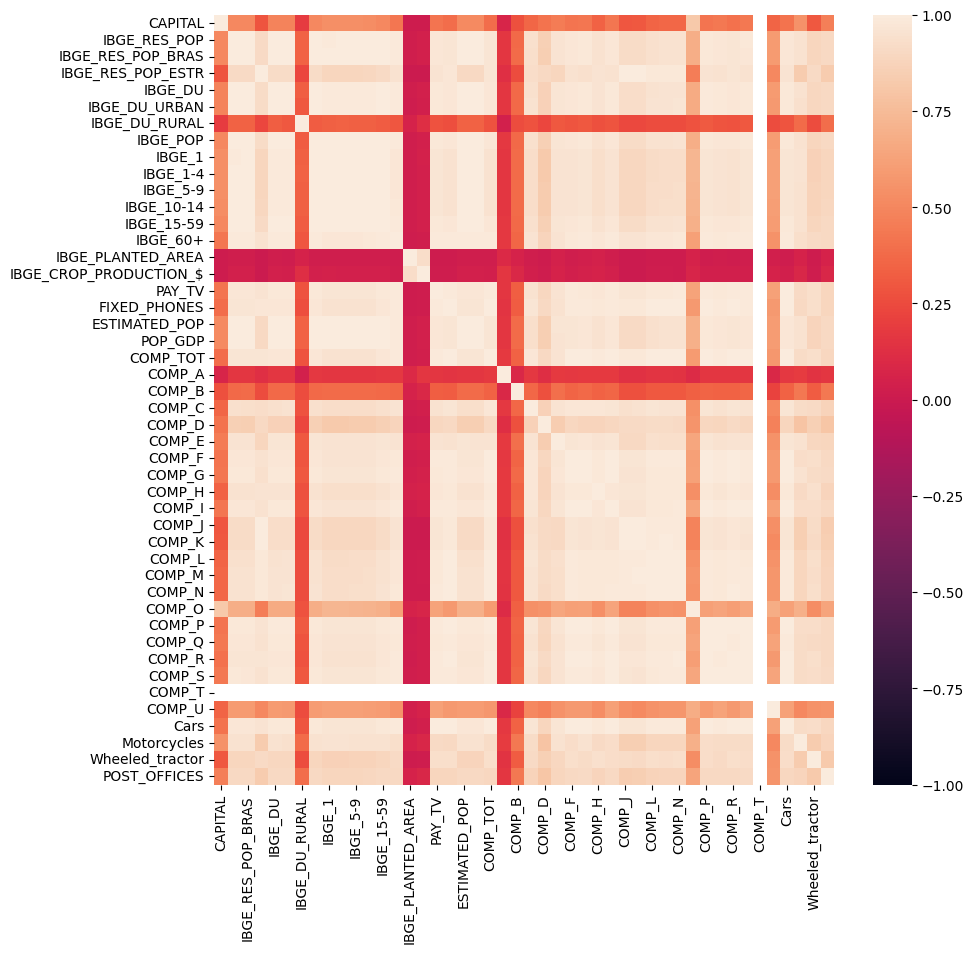

In [9]:
# Ploting correlation map
plt.figure(figsize=(10,10))

correlation = data.corr(method = 'pearson')
# sns.heatmap(correlation, annot = True, vmin = -1, cmap = "rocket")
sns.heatmap(correlation, vmin = -1)

plt.show()
plt.close()

## One hot encode

In [10]:
# Selecting columns with data type 'string';
# Try convert data type to float;
# Get the keys to perform the hot encode process;
# One hot encode.

dictionary = (data.dtypes).to_dict()

keysToHotEncode = []
for key, value in dictionary.items():
    if value == "object":
        if is_decimal(data[key][0]):
            # Try convert data type to float
            try:
                data[key] = data[key].astype(float)
            except ValueError:
                pass
        # Get the keys to perform the hot encode process
        else:
            keysToHotEncode.append(key)
            
# one hot encode           
data = hotencode(data, keysToHotEncode)

## Dimensionality reduction

In [11]:
y = data['IDHM']
x = data.drop('IDHM', axis=1)

# Data normalization
normal = MinMaxScaler(feature_range=(0,1))
x = normal.fit_transform(x)

In [12]:
arange = np.arange(2,81,3)
pcaList = []
for k in arange:
    pca = PCA(n_components=k)
    xPCA = pca.fit_transform(x)
    pcaList.append(pca.explained_variance_ratio_.sum())

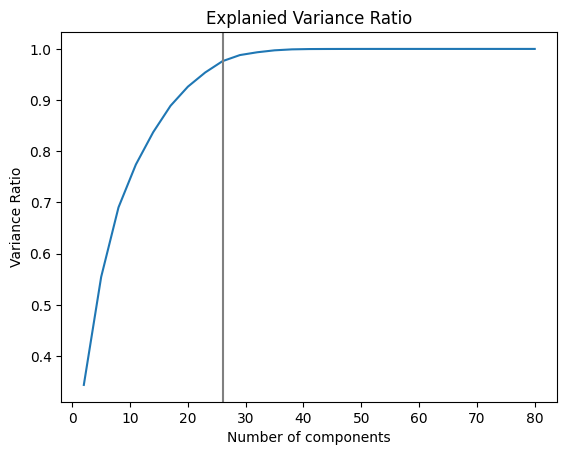

In [13]:
# Choosing the degree of dimensionality reduction

plt.title("Explanied Variance Ratio")
plt.plot(arange, pcaList)

plt.axvline(x=26, ymin=0, ymax=1, color='gray')

plt.xlabel("Number of components")
plt.ylabel("Variance Ratio")

plt.show()
plt.close()

In [14]:
# class sklearn.decomposition.PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto', random_state=None)
pca = PCA(n_components=26)
xPCA = pca.fit_transform(x)

print("PCA Sum: ", pca.explained_variance_ratio_.sum())
print("PCA list: \n", pca.explained_variance_ratio_)

PCA Sum:  0.9761209858416053
PCA list: 
 [0.23930851 0.10413774 0.09106101 0.06494208 0.05495817 0.05014917
 0.04711134 0.03874791 0.0315269  0.02675338 0.02536306 0.02302413
 0.02060885 0.01960797 0.01820122 0.01698343 0.01641742 0.01484446
 0.01219992 0.01027375 0.00955855 0.00930957 0.00890099 0.00873521
 0.00711175 0.00628451]


# Model

In [15]:
# Doc.:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

model = RandomForestRegressor(n_estimators=5)
kfold = KFold(n_splits=3)
crossValScore = cross_val_score(model, xPCA, y, cv=kfold)

print("Peformance: ", float("%0.4f" % (crossValScore.mean())))

Peformance:  0.7956


In [16]:
# Fine tuning of parameters
# Doc.:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

model = RandomForestRegressor(n_estimators=5, n_jobs=-1)

max_depth = [9,10,11]
min_samples_split = [12,13,14]
min_samples_leaf = [12,13,14]

gridValue = {'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf}

grid = GridSearchCV( estimator = model, param_grid = gridValue, cv=3)
grid.fit(xPCA, y)

print('R2: ', grid.best_score_)
print('max_depth: ', grid.best_estimator_.max_depth)
print('min_samples_split: ', grid.best_estimator_.min_samples_split)
print('min_samples_leaf: ', grid.best_estimator_.min_samples_leaf)


max_depth = grid.best_estimator_.max_depth
min_samples_split = grid.best_estimator_.min_samples_split
min_samples_leaf = grid.best_estimator_.min_samples_leaf

R2:  0.8104080144143513
max_depth:  10
min_samples_split:  14
min_samples_leaf:  12


In [17]:
# Data separation (i=train, f=test)
xi,xf,yi,yf = train_test_split(xPCA,y, test_size=0.3) 

# Fiting model
model = RandomForestRegressor(n_estimators=100,
                              max_depth = max_depth,
                              min_samples_split = min_samples_split,
                              min_samples_leaf = min_samples_leaf,
                              n_jobs=-1)
model.fit(xi,yi)

score = model.score(xf,yf)
print("R2: ", float("%0.4f" % (score)) )

# Fitting y_test
yPredict = model.predict(xf)

R2:  0.8046


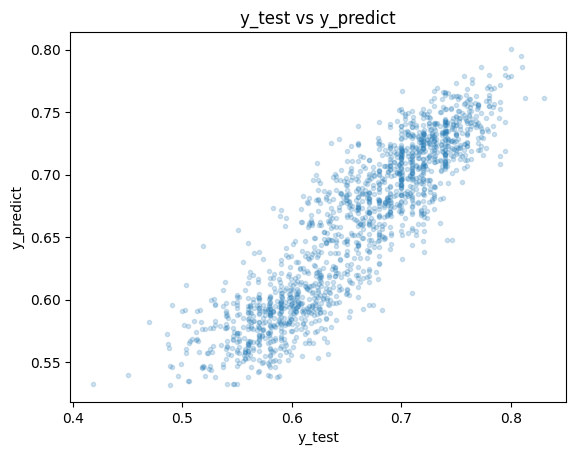

In [18]:
plt.title('y_test vs y_predict')

plt.scatter(yf, yPredict, marker='.', alpha=0.2)

plt.xlabel('y_test')
plt.ylabel('y_predict')

plt.show()